# Gender recognition based on image analysis

# Import libraries

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from PIL import Image
from google.colab.patches import cv2_imshow
from google.colab import drive
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras import callbacks

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
os.chdir('/content')
os.getcwd()

'/content'

### CelebA Dataset

In [ ]:
!unzip "/content/drive/MyDrive/archive.zip"

Archive:  /content/drive/MyDrive/archive.zip
replace img_align_celeba/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace img_align_celeba/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace img_align_celeba/img_align_celeba/000002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
! mkdir /content/train
! mkdir /content/test
! mkdir /content/valid

In [ ]:
! mkdir /content/train/male
! mkdir /content/train/female
! mkdir /content/test/male
! mkdir /content/test/female
! mkdir /content/valid/male
! mkdir /content/valid/female

# Data Exploration

In [ ]:
df1 = pd.read_csv('list_attr_celeba.csv')
df2 = pd.read_csv('list_bbox_celeba.csv')
df3 = pd.read_csv('list_eval_partition.csv')
df4 = pd.read_csv('list_landmarks_align_celeba.csv')

In [ ]:
img_list = df1['image_id']

In [ ]:
df1.info()

In [ ]:
print("Number of rows in the data:", df1.shape[0])
print("Number of columns in the data:", df1.shape[1])

In [59]:
df1.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


** Dictionary to name the prediction: 1 and 0**

- 0: 'Female'
- 1: 'Male'

In [ ]:
df1.replace(-1,0,inplace=True)
df1['Male'].replace(0,'K',inplace=True)
df1['Male'].replace(1,'M',inplace=True)
df1

In [ ]:
df1_drop_imageID = df1.drop(['image_id'], axis=1)
cols = df1_drop_imageID.columns

In [ ]:
for col in cols:
  print(df1_drop_imageID[col].value_counts())

In [ ]:
fig, ax = plt.subplots(figsize=(26, 9))
width = 0.4
labels = cols
index = np.arange(len(labels))
zeros = []
ones = []
for col in cols:
  a = df1_drop_imageID[col].value_counts()
  zeros.append(a[0])
  ones.append(a[1])
plt.bar(index - width/2, zeros, width, label='0')
plt.bar(index + width/2, ones, width, label='1')
plt.xticks(index, labels)
plt.xticks(rotation = 90)
plt.legend()
plt.title('Rozkład zer i jedynek w poszczególnych zmiennych',size=20 )
plt.show()

In [ ]:
df1_counts = df1.Male.value_counts()
df1_counts

Distribution of the Attribute in CelebA dataset

In [ ]:
for i, j in enumerate(df1.columns):
    print(i, j)

Display the first photo

In [ ]:
img = cv2.imread('img_align_celeba/img_align_celeba/'+img_list[0])
n_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(n_img)

In [ ]:
n_img.shape

Display eight randomly selected photos

In [ ]:
pics = 16
rand_pics = random.choices(img_list, k = pics)
fig = plt.figure(figsize=(15, 7))
x = 1
rows = 2
cols = pics / rows
for pic in rand_pics:
  img = cv2.imread('img_align_celeba/img_align_celeba/'+pic)
  fig.add_subplot(rows, int(cols), x)
  plt.imshow(img)
  plt.axis('off')
  plt.title(pic)
  x+=1

### Comparison of the contents of the set

In [ ]:
sns.set_theme(style="darkgrid")
sns.countplot(df1['Male'], data=df1)
plt.title('Female or Male')
plt.show()

There are more women than men in the dataset.

## Split Dataset into Training, Validation and Test 

Images 1-162770 are training, 162771-182637 are
validation, 182638-202599 are  testing

    1-162770 train
    162771-182637 valid
    182638-202599 test


In [ ]:
df1_1 = pd.read_csv('list_attr_celeba.csv')
import shutil
for i in range(0,162771):
    if df1_1['Male'][i]==1:
        shutil.copy('/content/img_align_celeba/img_align_celeba/'+img_list[i],'/content/train/male')
    else:
        shutil.copy('/content/img_align_celeba/img_align_celeba/'+img_list[i],'/content/train/female')
for i in range(162771,182638):
    if df1_1['Male'][i]==1:
        shutil.copy('/content/img_align_celeba/img_align_celeba/'+img_list[i],'/content/valid/male')
    else:
        shutil.copy('/content/img_align_celeba/img_align_celeba/'+img_list[i],'/content/valid/female')
for i in range(182638,len(img_list)):
    if df1_1['Male'][i]==1:
        shutil.copy('/content/img_align_celeba/img_align_celeba/'+img_list[i],'/content/test/male')
    else:
        shutil.copy('/content/img_align_celeba/img_align_celeba/'+img_list[i],'/content/test/female')

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255.)
valid_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

In [ ]:
train_generator = train_datagen.flow_from_directory('/content/train/',
    target_size=(124, 100),
    batch_size=64,
    class_mode='binary',
    shuffle=True,
    color_mode='rgb')

valid_generator = valid_datagen.flow_from_directory('/content/valid/',
    target_size=(124, 100),
    batch_size=64,
    class_mode='binary',
    shuffle=True,
    color_mode='rgb')

test_generator = test_datagen.flow_from_directory('/content/test/',
    target_size=(124, 100),
    batch_size=64,
    class_mode='binary',
    shuffle=True,
    color_mode='rgb')


Build Sequential model

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(124,100,3),kernel_initializer='he_uniform',padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform',padding='same'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_uniform',padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_uniform',padding='same'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())

model.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(1,activation='sigmoid'))

model.summary()

In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9)
model.compile(optimizer=opt,
              loss='mae',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras import callbacks
early_stopping = callbacks.EarlyStopping(
    patience=1,
    min_delta=0.001,
    restore_best_weights=True,
) 

In [28]:
batch_size = 512
history = model.fit(
    train_generator,
    steps_per_epoch = 162771 / batch_size,
    validation_steps = 19867 / batch_size,
    epochs=20,
    batch_size = batch_size,
    # y=valid_generator,
    validation_data=valid_generator,
    callbacks=[early_stopping])

Epoch 1/20
317/317 [==============================] - 1687s 5s/step - loss: 0.4150 - accuracy: 0.5855 - val_loss: 0.4284 - val_accuracy: 0.5713
Epoch 2/20
317/317 [==============================] - 1586s 5s/step - loss: 0.3661 - accuracy: 0.6421 - val_loss: 0.2328 - val_accuracy: 0.7780
Epoch 3/20
317/317 [==============================] - 1595s 5s/step - loss: 0.2010 - accuracy: 0.8119 - val_loss: 0.1580 - val_accuracy: 0.8530
Epoch 4/20
317/317 [==============================] - 1579s 5s/step - loss: 0.1492 - accuracy: 0.8632 - val_loss: 0.1072 - val_accuracy: 0.9067
Epoch 5/20
317/317 [==============================] - 1595s 5s/step - loss: 0.1055 - accuracy: 0.9089 - val_loss: 0.0743 - val_accuracy: 0.9383
Epoch 6/20
317/317 [==============================] - 1592s 5s/step - loss: 0.0814 - accuracy: 0.9292 - val_loss: 0.0713 - val_accuracy: 0.9351
Epoch 7/20
317/317 [==============================] - 1546s 5s/step - loss: 0.0779 - accuracy: 0.9301 - val_loss: 0.0644 - val_accuracy:

In [29]:
test_accuracy_model = model.evaluate(test_generator)[1]

312/312 [==============================] - 410s 1s/step - loss: 0.0703 - accuracy: 0.9366


In [60]:
print(f'accuracy on the test set: {round(test_accuracy_model, 4)}')

accuracy on the test set: 0.9366


## Conclusion

Minimum Validation Loss: 0.0644


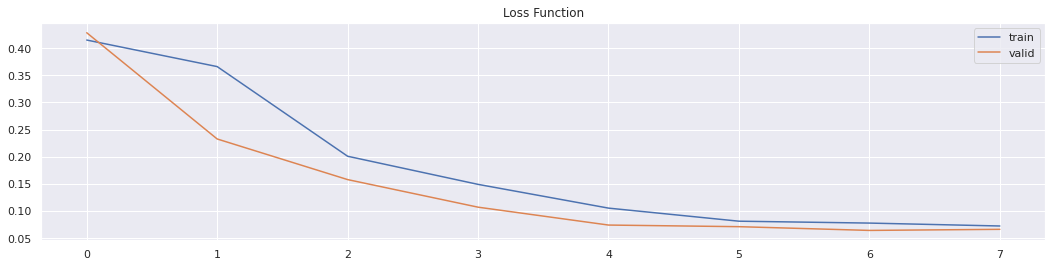

In [31]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
history_df = pd.DataFrame(history.history)
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));
plt.show()

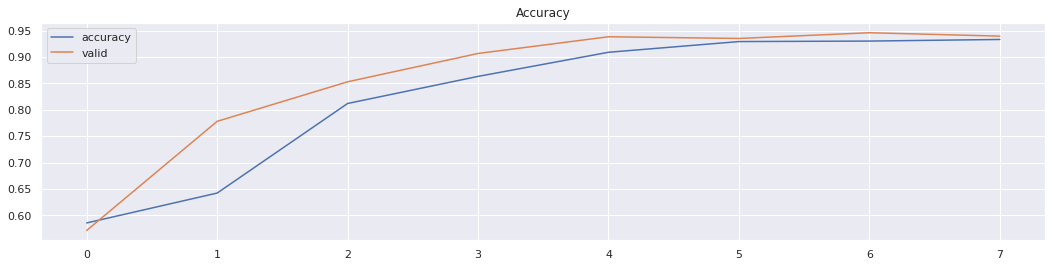

In [32]:
plt.figure(figsize=(18, 4))
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

## Gender recognition in basic sample photos

In [62]:
def gender_prediction(filename):
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (100, 124)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    # prediction
    result = model.predict(im)
    prediction = np.argmax(result)
    return result

In [63]:
df_to_test = df3[(df3['partition'] == 2)].sample(8)

In [64]:
def show_image(img):
  cv2_imshow(cv2.imread(img))

1/1 [==============================] - 0s 37ms/step


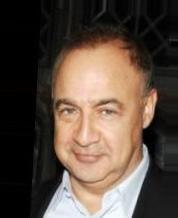

The probability that there is a man in the photo:  [0.9991815]
The probability that there is a man in the photo of atribiute:  188073    M
Name: Male, dtype: object
 
1/1 [==============================] - 0s 34ms/step


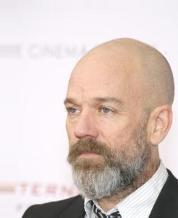

The probability that there is a man in the photo:  [0.99999535]
The probability that there is a man in the photo of atribiute:  183849    M
Name: Male, dtype: object
 
1/1 [==============================] - 0s 38ms/step


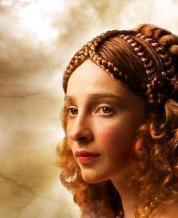

The probability that there is a man in the photo:  [0.04302214]
The probability that there is a man in the photo of atribiute:  186530    K
Name: Male, dtype: object
 
1/1 [==============================] - 0s 49ms/step


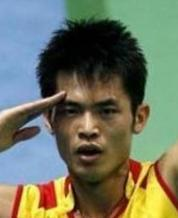

The probability that there is a man in the photo:  [0.9999627]
The probability that there is a man in the photo of atribiute:  187563    M
Name: Male, dtype: object
 
1/1 [==============================] - 0s 38ms/step


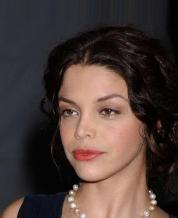

The probability that there is a man in the photo:  [1.3415743e-06]
The probability that there is a man in the photo of atribiute:  187508    K
Name: Male, dtype: object
 
1/1 [==============================] - 0s 37ms/step


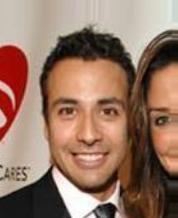

The probability that there is a man in the photo:  [0.99993134]
The probability that there is a man in the photo of atribiute:  187590    M
Name: Male, dtype: object
 
1/1 [==============================] - 0s 41ms/step


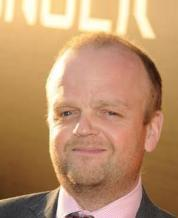

The probability that there is a man in the photo:  [0.9213056]
The probability that there is a man in the photo of atribiute:  185033    M
Name: Male, dtype: object
 
1/1 [==============================] - 0s 37ms/step


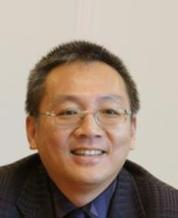

The probability that there is a man in the photo:  [0.9143247]
The probability that there is a man in the photo of atribiute:  200402    M
Name: Male, dtype: object
 


In [77]:
for index, target in df_to_test.iterrows():
    result = gender_prediction('img_align_celeba/img_align_celeba/'+target[0])
    show_image('img_align_celeba/img_align_celeba/'+target[0])
    print(f'The probability that there is a man in the photo: ', result[0])
    print(f'The probability that there is a man in the photo of atribiute: ', df1['Male'].loc[df1['image_id']==target[0]])
    print(' ')

## Recognition of our photos

In [41]:
! mkdir /content/drive/MyDrive/our_photos

mkdir: cannot create directory ‘/content/drive/MyDrive/our_photos’: File exists


In [48]:
os.chdir('/content/drive/MyDrive/our_photos')

In [52]:
df5=['mateusz.jpg', 'iza.jpg', 'agnieszka.jpg']

1/1 [==============================] - 0s 36ms/step


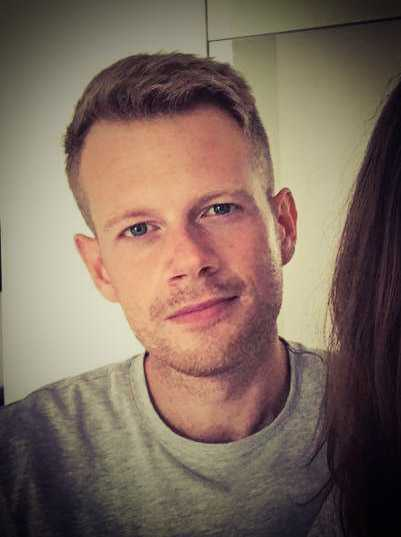

Prawdopodobieństwo, że na zdjęciu jest mężczyzna:  [[0.999926]]
 
1/1 [==============================] - 0s 49ms/step


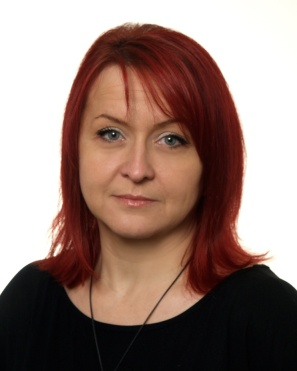

Prawdopodobieństwo, że na zdjęciu jest mężczyzna:  [[0.9999995]]
 
1/1 [==============================] - 0s 61ms/step


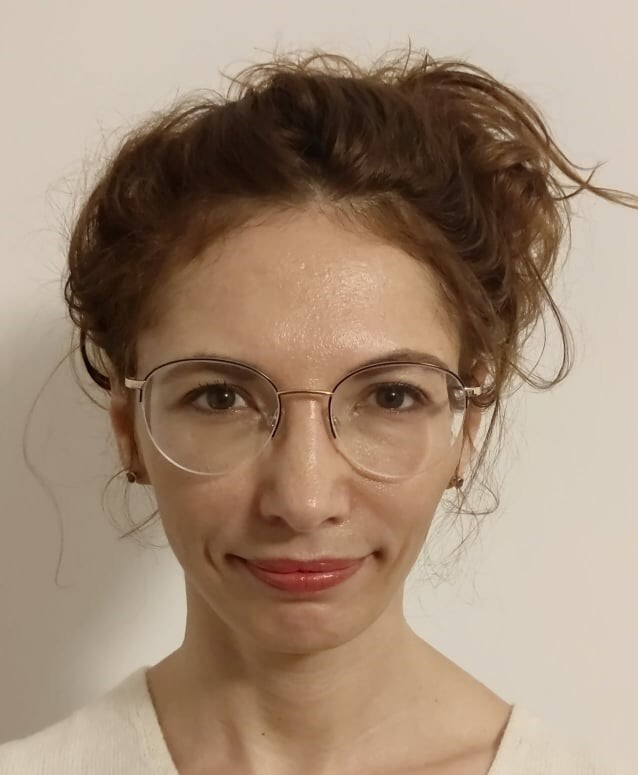

Prawdopodobieństwo, że na zdjęciu jest mężczyzna:  [[0.00134481]]
 


In [58]:
for photo in df5:
    result = gender_prediction(photo)
    show_image(photo)
    print(f'Prawdopodobieństwo, że na zdjęciu jest mężczyzna: ', result)
    print(' ')

** Scrapy vs BeautifulSoup**

In [71]:
import bs4
import urllib.request
from urllib.request import urlopen
from bs4 import BeautifulSoup

#Get the URL
url= 'https://www.filmweb.pl/serial/Peaky+Blinders-2013-680981/cast/actors'
page = urllib.request.urlopen(url)
#Parse HTML page
page_soup = BeautifulSoup(page, 'html.parser')
img_items = page_soup.findAll('div', {'class':'castRoleListElement__image'})

In [72]:
len(img_items)

56

In [73]:
img_items = img_items[:7]

In [74]:
i = 1
for img in img_items:
    img_tag = img.find('img')
    img_src = img_tag.get('data-src')
    file_name = str(i)
    i+=1
    img_file = open(str(file_name) + '.jpeg','wb')
    img_file.write(urllib.request.urlopen(img_src).read())
    img_file.close()
    print(img_src)

https://fwcdn.pl/fph/09/81/680981/447735.2.jpg
https://fwcdn.pl/fph/09/81/680981/447731.2.jpg
https://fwcdn.pl/fph/09/81/680981/447674_2.2.jpg
https://fwcdn.pl/fph/09/81/680981/447672.2.jpg
https://fwcdn.pl/fph/09/81/680981/552160_1.2.jpg
https://fwcdn.pl/fph/09/81/680981/447678_1.2.jpg
https://fwcdn.pl/fph/09/81/680981/447721_1.2.jpg


1/1 [==============================] - 0s 34ms/step


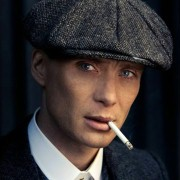

The probability that there is a man in the photo:  [[0.99997896]]
 
1/1 [==============================] - 0s 34ms/step


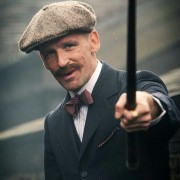

The probability that there is a man in the photo:  [[0.9509533]]
 
1/1 [==============================] - 0s 38ms/step


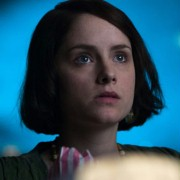

The probability that there is a man in the photo:  [[0.8283933]]
 
1/1 [==============================] - 0s 43ms/step


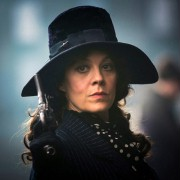

The probability that there is a man in the photo:  [[0.9999861]]
 
1/1 [==============================] - 0s 44ms/step


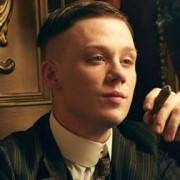

The probability that there is a man in the photo:  [[0.99995196]]
 
1/1 [==============================] - 0s 39ms/step


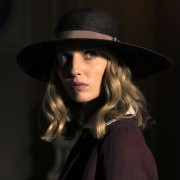

The probability that there is a man in the photo:  [[0.9815253]]
 
1/1 [==============================] - 0s 38ms/step


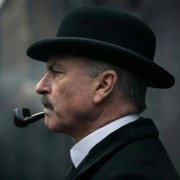

The probability that there is a man in the photo:  [[0.9989868]]
 


In [75]:
os.chdir('/content/drive/MyDrive/jpeg_Peaky_Blinders')
df6=['1.jpeg', '2.jpeg', '3.jpeg', '4.jpeg', '5.jpeg', '6.jpeg', '7.jpeg']
for photo in df6:
    result = gender_prediction(photo)
    show_image(photo)
    print(f'The probability that there is a man in the photo: ', result)
    print(' ')